#### Notebook Objective:
This notebook is aimed at evaluating the performance of  ONLY non-text features to see if they can make decent estimates on the `deal_type` without any text processing

---
#### Import libraries

In [1]:
#Import basic data science libraries
import pandas as pd
import numpy as np

#Visuals basic
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#Importing preprocessing model support libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [3]:
# importing the GridSearchCV class from model_selection submodule of scikit learn to cross validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

#To save the models
import pickle

In [4]:
#Importing Classification Models
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

#Import Evaluation metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

#Import PCA
from sklearn.decomposition import PCA 

#Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

---
#### Import data and Inspect

In [5]:
master = pd.read_csv('clean_data_w_deal.csv')

In [6]:
master.shape

(31604, 118)

In [7]:
master.head()

,title,summary,description,transit,house_rules,max_guests,bathrooms,bedrooms,beds,price,...,cancellation_policy_moderate,cancellation_policy_strict,room_type_entire_home/apt,room_type_private_room,room_type_shared_room,experiences_offered_business,experiences_offered_family,experiences_offered_none,experiences_offered_romantic,experiences_offered_social
0,Quiet Room in Leafy Village near Central London,"My place is good for couples, solo adventurers...","My place is good for couples, solo adventurers...","Free parking on street, on bus route to centra...",not_available,2,2.0,1.0,1.0,39.0,...,0,0,0,1,0,0,0,1,0,0
1,Spacious room in private house.,Newly-decorated double room in beautiful house...,Newly-decorated double room in beautiful house...,Excellent transport links. Five minutes easy w...,"Sorry, but no smokers please.",2,1.0,1.0,1.0,45.0,...,0,0,0,1,0,0,0,1,0,0
2,Bright room in lovely area plus C/Breakfast,Quiet location in smart area with good restaur...,Quiet location in smart area with good restaur...,not_available,Early Check In Weekends only from 1 o Clock on...,3,1.0,1.0,2.0,60.0,...,0,0,0,1,0,0,0,1,0,0
3,"Bright, airy room by Tower Bridge and river","For solo travellers: Bright, airy room in ver...","For solo travellers: Bright, airy room in ver...",Walking In under 5 minutes you can be at Tower...,We are looking for respectful guests to share ...,1,1.0,1.0,1.0,55.0,...,0,0,0,1,0,0,0,1,0,0
4,Bright apartment at London Bridge,A bright and quiet apartment in Central London...,A bright and quiet apartment in Central London...,not_available,I would like that my guests feel like at their...,2,1.0,1.0,1.0,75.0,...,1,0,1,0,0,0,0,1,0,0


In [8]:
#Checking for any null values
(master.isna().sum() > 0).value_counts()

False    118
dtype: int64

In [9]:
#making a copy of master to use for classification modelling
deal_df = master.copy()

In [10]:
#Print all column names to show them all
for i in range(0, deal_df.columns.shape[0]):
    print (deal_df.columns[i])

title
summary
description
transit
house_rules
max_guests
bathrooms
bedrooms
beds
price
cleaning_fee
guests_included
charge_per_extra_guest
total_reviews
overall_rating
accuracy_rating
cleanliness_rating
check_in_rating
communication_rating
location_rating
value_rating
reviews_per_month
beds_per_bedroom
max_guests_per_bed
included_guests_per_bed
add_guests_upsell
professionally_managed
real_bed
relative_avg_price
deal_type
24-hour_check-in
air_conditioning
breakfast
buzzer/wireless_intercom
carbon_monoxide_detector
doorman
dryer
elevator_in_building
essentials
family/kid_friendly
fire_extinguisher
first_aid_kit
free_parking_on_premises
gym
heating
hot_tub
indoor_fireplace
internet
iron
keypad
kitchen
laptop_friendly_workspace
lock_on_bedroom_door
other_pet(s)
pets_allowed
pets_live_on_this_property
pool
private_entrance
private_living_room
safety_card
self_check-in
shampoo
smoke_detector
smoking_allowed
suitable_for_events
tv
washer
wheelchair_accessible
wireless_internet
host_identity_

In [11]:
#Make a list of text columns to drop them
drop_col = ['transit', 'house_rules', 'title', 'summary', 'description', 'host_response_time_not_available']

In [12]:
deal_df.drop(drop_col, inplace = True, axis = 1)

In [13]:
deal_df.shape

(31604, 112)

##### Merging NLP output with probability

In [14]:
#loading up 
text_predictions = pd.read_csv('nlp_predictions_logreg.csv')

In [15]:
# sneak-peak
text_predictions.head()

,0,1,2
0,0.255479,0.236011,0.508510
1,0.172043,0.419255,0.408702
2,0.212678,0.376720,0.410602
3,0.292958,0.500203,0.206839
4,0.340291,0.457132,0.202577


In [16]:
#merge them using concat
deal_df = pd.concat([deal_df, text_predictions], axis=1)

In [17]:
deal_df.shape

(31604, 115)

#### Check for target class imbalance

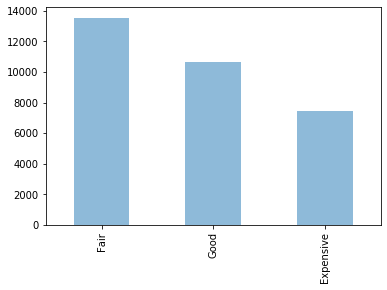

In [18]:
deal_df.deal_type.value_counts().plot(kind='bar', alpha = 0.5)

In [19]:
deal_df.deal_type.value_counts()

Fair         13547
Good         10624
Expensive     7433
Name: deal_type, dtype: int64

Lets do random resampling of the target variables to have equal classes.
We will use SMOTE method to balance the target variable on our training dataset after the split to ensure the model is trained on balanced data without any data leakage

## Train-Test Split


In [20]:
#Allocating Features and Target variables to X and y 
X = deal_df.loc[:, deal_df.columns != 'deal_type']
y = deal_df['deal_type']

# We will stratify in order to ensure our data is evenly split for all deal_types 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 88)

In [21]:
#addressing Imbalance dataset using SMOTE method
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 8, sampling_strategy = 'all', k_neighbors=3)
X_rem, y_rem = sm.fit_sample(X_train, y_train)

---

Check to make sure our data is in right shape to be fed into ML models.

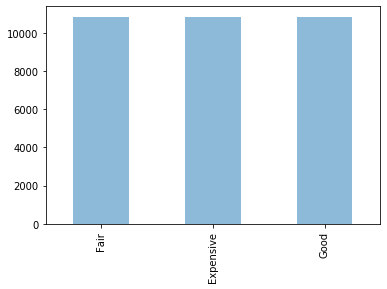

In [22]:
#Checking to ensure the data are balanced (visuals)
y_rem.value_counts().plot(kind='bar', alpha = 0.5)

In [23]:
#Checking for training set values.
y_rem.value_counts()

Fair         10838
Expensive    10838
Good         10838
Name: deal_type, dtype: int64

In [24]:
#checking for test target to ensure it reflects real world data.
y_test.value_counts()

Fair         2709
Good         2125
Expensive    1487
Name: deal_type, dtype: int64

In [25]:
#printing complete dataset shape
print(f'The shape of our features are: {X.shape}')
print(f'The shape of our features are: {y.shape} \n')


# Printing training dataset shape after the split and rebalancing. 
print('Training set size:')
print(f'X_rem: {X_rem.shape}')
print(f'y_rem: {y_rem.shape} \n')


# Printing Test dataset shape after the split and rebalancing
print('Testing set size:')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

The shape of our features are: (31604, 114)
The shape of our features are: (31604,) 

Training set size:
X_rem: (32514, 114)
y_rem: (32514,) 

Testing set size:
X_test: (6321, 114)
y_test: (6321,)


---

### Modelling with GridSearch Cross-Validation

##### Build a pipeline

In [26]:
#instantiate pipeline 
model_pipeline = Pipeline([('scaler', StandardScaler()),('dim_reducer', PCA()), ('model', LogisticRegression())])

--- 
##### Logistic Regression

In [27]:
# Intiate a parameter grid for logistic regression
logreg_param_grid = [
    
    {'scaler': [StandardScaler()],
    'dim_reducer': [PCA()],
    'dim_reducer__n_components': [None],
    'model': [LogisticRegression(random_state = 8, n_jobs = -1)],
    'model__C': [0.01, 0.1, 1, 10],
    'model__solver': ['lbfgs','sag','saga']}
]

##### Note:
No PCA applied by setting `n_components` = `None` as it significantly reduces the prerformance of the model.

In [28]:
# Instantiate the logistic regression grid search
logreg_gs = GridSearchCV(model_pipeline, param_grid=logreg_param_grid, cv=5, verbose=1, scoring = 'accuracy')

In [29]:
%%time

#Fitting the logistic Regression GridSearch
fitted_logreg_gs = logreg_gs.fit(X_rem, y_rem)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 12.5min finished


Wall time: 12min 44s


---

In [30]:
#Check for best parameters and best score 

print("Best Parameters: ", fitted_logreg_gs.best_params_)
print("\nBest Score: ", fitted_logreg_gs.best_score_)

Best Parameters:  {'dim_reducer': PCA(), 'dim_reducer__n_components': None, 'model': LogisticRegression(C=10, n_jobs=-1, random_state=8), 'model__C': 10, 'model__solver': 'lbfgs', 'scaler': StandardScaler()}

Best Score:  0.9683524292528926


In [31]:
#Use model to predict test set
y_pred_logreg = fitted_logreg_gs.predict(X_test)

In [32]:
#Compare Training and Test set scores to ensure we are not over or under-fitting

print('Training Score: ', fitted_logreg_gs.score(X_rem,y_rem))
print('Test Score: ', fitted_logreg_gs.score(X_test,y_test))

Training Score:  0.9744110229439626
Test Score:  0.9604492959974688


Classification Report 
               precision    recall  f1-score   support

   Expensive       0.98      0.96      0.97      1487
        Fair       0.95      0.96      0.95      2709
        Good       0.96      0.96      0.96      2125

    accuracy                           0.96      6321
   macro avg       0.96      0.96      0.96      6321
weighted avg       0.96      0.96      0.96      6321



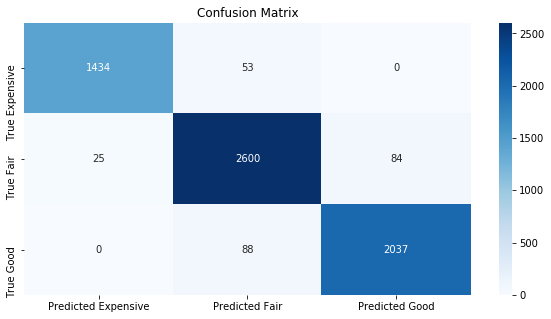

In [33]:
# Setting up our confusion matrix 
logreg_confusion_matrix = confusion_matrix(y_test,y_pred_logreg)

# Making a DataFrame of Confustion matrix for readability
logreg_confusion_matrix = pd.DataFrame(data = logreg_confusion_matrix,\
                                   columns = ['Predicted Expensive', 'Predicted Fair', 'Predicted Good'],\
                                  index = ['True Expensive','True Fair', 'True Good'])

# Setting up our classification_report
logreg_classification_report = classification_report(y_test,y_pred_logreg)
logreg_scores_dict = classification_report(y_test,y_pred_logreg, output_dict = True)

# Print Classification report
print(f'Classification Report \n {logreg_classification_report}')

# Visualizing the confusion matrix heatmap
plt.figure(figsize = (10,5))
sns.heatmap(logreg_confusion_matrix, annot = True, cmap='Blues', fmt = 'g')
plt.title('Confusion Matrix')
plt.show()

--- 

##### Decision Trees

---

In [34]:
# Intiate a parameter grid for DecisionTreeClassifier
dt_param_grid = [
    
    {'scaler': [None],
    'dim_reducer': [PCA()],
    'dim_reducer__n_components': [.9,.95,.99],
    'model': [DecisionTreeClassifier(random_state = 8)],
    'model__max_depth': [5,10,20,30],
    'model__max_features': ['auto', 'log2', None]}
]

##### Note: 
Scaler is set to none as Decision Trees are immune to scaling. Therefore to save on computational power we will not scale the training data.

In [35]:
# Instantiate the DecisionTrees Grid Search Cross Validation
dt_gs = GridSearchCV(model_pipeline, param_grid=dt_param_grid, cv=5, verbose=1, scoring = 'accuracy')

In [36]:
%%time


#Fitting the DT GS-CV
fitted_dt_gs = dt_gs.fit(X_rem, y_rem)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  4.0min finished


Wall time: 3min 59s


---

In [37]:
#Check for best parameters and best score 

print("Best Parameters: ", fitted_dt_gs.best_params_)
print("\nBest Score: ", fitted_dt_gs.best_score_)

Best Parameters:  {'dim_reducer': PCA(n_components=0.95), 'dim_reducer__n_components': 0.95, 'model': DecisionTreeClassifier(max_depth=30, random_state=8), 'model__max_depth': 30, 'model__max_features': None, 'scaler': None}

Best Score:  0.9234795544048406


In [38]:
#Use best model to predict test set values

y_pred_dt = fitted_dt_gs.predict(X_test)

In [39]:
#Compare Training and Test set scores to ensure we are not over or under-fitting

print('Training Score: ', fitted_dt_gs.score(X_rem,y_rem))
print('Test Score: ', fitted_dt_gs.score(X_test,y_test))

Training Score:  1.0
Test Score:  0.9079259610821072


Classification Report 
               precision    recall  f1-score   support

   Expensive       0.92      0.93      0.93      1487
        Fair       0.90      0.88      0.89      2709
        Good       0.91      0.92      0.91      2125

    accuracy                           0.91      6321
   macro avg       0.91      0.91      0.91      6321
weighted avg       0.91      0.91      0.91      6321



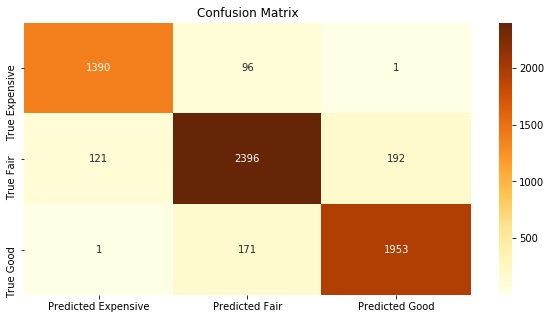

In [40]:
# Setting up our confusion matrix 
dt_confusion_matrix = confusion_matrix(y_test,y_pred_dt)

# Making a DataFrame of Confustion matrix for readability
dt_confusion_matrix = pd.DataFrame(data = dt_confusion_matrix,\
                                   columns = ['Predicted Expensive', 'Predicted Fair', 'Predicted Good'],\
                                  index = ['True Expensive','True Fair', 'True Good'])

# Setting up classification_report for decision tree model
dt_classification_report = classification_report(y_test,y_pred_dt)
dt_scores_dict = classification_report(y_test,y_pred_dt, output_dict = True)

# Printing classification report
print(f'Classification Report \n {dt_classification_report}')

# Visualizing the confusion matrix heatmap
plt.figure(figsize = (10,5))
sns.heatmap(dt_confusion_matrix, annot = True, cmap='YlOrBr', fmt = 'g')
plt.title('Confusion Matrix')
plt.show()

---

##### RandomForestClassifier

---

In [41]:
# Intiate a parameter grid for Random Forest Classifier

rf_param_grid = [
    
    {'scaler': [None],
    'dim_reducer': [PCA()],
    'dim_reducer__n_components': [.9,.95,.99],
    'model': [RandomForestClassifier(random_state = 8, n_jobs = -1)],
    'model__max_depth': [5,10,20,30],
    'model__n_estimators': [100,200,300,400]}
]

##### Note: 
Scaler is set to none as Decision Trees are immune to scaling. Therefore to save on computational power we will not scale the training data.

##### Note: 
Scaler is set to None as RandomForests are immune to scaling. Therefore to save on computational power we will not scale the training data.

In [42]:
# Instantiate the logistic regression grid search
rf_gs = GridSearchCV(model_pipeline, param_grid=rf_param_grid, cv=5, verbose=1, scoring = 'accuracy')

In [43]:
%%time


#Fitting the logistic Reg GS
fitted_rf_gs = rf_gs.fit(X_rem, y_rem)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 26.4min finished


Wall time: 26min 30s


---

In [44]:
#Check for best parameters and best score 

print("Best Parameters: ", fitted_rf_gs.best_params_)
print("\nBest Score: ", fitted_rf_gs.best_score_)

Best Parameters:  {'dim_reducer': PCA(n_components=0.95), 'dim_reducer__n_components': 0.95, 'model': RandomForestClassifier(max_depth=20, n_estimators=300, n_jobs=-1,
                       random_state=8), 'model__max_depth': 20, 'model__n_estimators': 300, 'scaler': None}

Best Score:  0.9548197308835006


In [45]:
#Use best model to predict test set values

y_pred_rf = fitted_rf_gs.predict(X_test)

In [46]:
#Compare Training and Test set scores to ensure we are not over or under-fitting

print('Training Score: ', fitted_rf_gs.score(X_rem,y_rem))
print('Test Score: ', fitted_rf_gs.score(X_test,y_test))

Training Score:  1.0
Test Score:  0.9387755102040817


Classification Report 
               precision    recall  f1-score   support

   Expensive       0.95      0.95      0.95      1487
        Fair       0.93      0.93      0.93      2709
        Good       0.94      0.95      0.94      2125

    accuracy                           0.94      6321
   macro avg       0.94      0.94      0.94      6321
weighted avg       0.94      0.94      0.94      6321



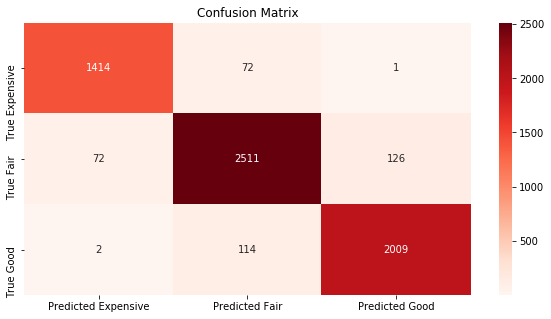

In [47]:
# Setting up our confusion matrix 
rf_confusion_matrix = confusion_matrix(y_test,y_pred_rf)

# Making a DataFrame of Confustion matrix for readability
rf_confusion_matrix = pd.DataFrame(data = rf_confusion_matrix,\
                                   columns = ['Predicted Expensive', 'Predicted Fair', 'Predicted Good'],\
                                  index = ['True Expensive','True Fair', 'True Good'])

# Setting up our classification_report
rf_classification_report = classification_report(y_test,y_pred_rf)
rf_scores_dict = classification_report(y_test,y_pred_rf, output_dict = True)

# Printing classification report
print(f'Classification Report \n {rf_classification_report}')

# Visualizing the confusion matrix heatmap
plt.figure(figsize = (10,5))
sns.heatmap(rf_confusion_matrix, annot = True, cmap='Reds', fmt = 'g')
plt.title('Confusion Matrix')
plt.show()

---

##### KNNs

---

In [48]:
knn_param_grid = [
    
    {'scaler': [StandardScaler()],
    'dim_reducer': [PCA()],
    'dim_reducer__n_components': [0.9,0.95,0.99],
    'model': [KNeighborsClassifier(n_jobs = -1)],
    'model__n_neighbors': [3,5,7,9],
    'model__weights': ['uniform', 'distance']}
]

In [49]:
# Instantiate the logistic regression grid search
knn_gs = GridSearchCV(model_pipeline, param_grid = knn_param_grid, cv=5, verbose=1, scoring = 'accuracy')

In [50]:
%%time


#Fitting the logistic Reg GS
fitted_knn_gs = knn_gs.fit(X_rem, y_rem)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 34.9min finished


Wall time: 34min 56s


---

In [51]:
#Check for best parameters and best score 

print("Best Parameters: ", fitted_knn_gs.best_params_)
print("\nBest Score: ", fitted_knn_gs.best_score_)

Best Parameters:  {'dim_reducer': PCA(n_components=0.99), 'dim_reducer__n_components': 0.99, 'model': KNeighborsClassifier(n_jobs=-1, n_neighbors=3, weights='distance'), 'model__n_neighbors': 3, 'model__weights': 'distance', 'scaler': StandardScaler()}

Best Score:  0.5726776411975203


In [52]:
#Use best model to predict test set values

y_pred_knn = fitted_knn_gs.predict(X_test)

In [53]:
#Compare Training and Test set scores to ensure we are not over or under-fitting

print('Training Score: ', fitted_knn_gs.score(X_rem,y_rem))
print('Test Score: ', fitted_knn_gs.score(X_test,y_test))

Training Score:  1.0
Test Score:  0.4807783578547698


Classification Report 
               precision    recall  f1-score   support

   Expensive       0.43      0.42      0.43      1487
        Fair       0.50      0.49      0.49      2709
        Good       0.49      0.52      0.50      2125

    accuracy                           0.48      6321
   macro avg       0.47      0.47      0.47      6321
weighted avg       0.48      0.48      0.48      6321



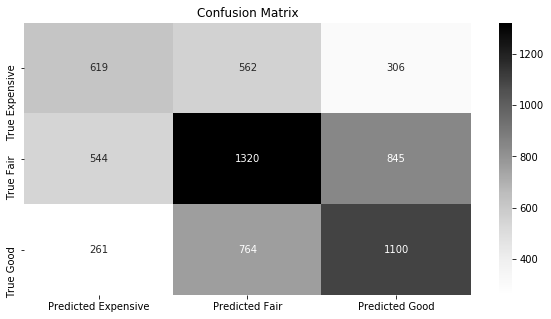

In [54]:
# Setting up our confusion matrix 
knn_confusion_matrix = confusion_matrix(y_test,y_pred_knn)

# Putting the confusion matrix in a DataFrame
knn_confusion_matrix = pd.DataFrame(data = knn_confusion_matrix,\
                                   columns = ['Predicted Expensive', 'Predicted Fair', 'Predicted Good'],\
                                  index = ['True Expensive','True Fair', 'True Good'])

# Setting up our classification_report
knn_classification_report = classification_report(y_test,y_pred_knn)
knn_scores_dict = classification_report(y_test,y_pred_knn, output_dict = True)

# Printing classification report
print(f'Classification Report \n {knn_classification_report}')

# Visualizing the heatmap
plt.figure(figsize = (10,5))
sns.heatmap(knn_confusion_matrix, annot = True, cmap='Greys', fmt = 'g')
plt.title('Confusion Matrix')
plt.show()

---

##### Supprt Vector Classification (SVC)

---

In [55]:
# Intiate a parameter grid for SVC 

svm_param_grid = [
    
    {'scaler': [StandardScaler()],
    'dim_reducer': [PCA()],
    'dim_reducer__n_components': [None],
    'model': [SVC(random_state = 8)],
    'model__C': [0.1,1,10],
    'model__kernel': ['rbf', 'sigmoid'],
    'model__gamma': ['auto', 'scale']}
]

##### Note:
No PCA applied by setting `n_components` = `None` as it significantly reduces the prerformance of the model.

In [56]:
# Instantiate the logistic regression grid search
svm_gs = GridSearchCV(model_pipeline, param_grid=svm_param_grid, cv=5, verbose=1, scoring = 'accuracy')

In [57]:
%%time


#Fitting the logistic Reg GS
fitted_svm_gs = svm_gs.fit(X_rem, y_rem)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 180.3min finished


Wall time: 3h 8min 52s


---


In [58]:
#Check for best parameters and best score 

print("Best Parameters: ", fitted_svm_gs.best_params_)
print("\nBest Score: ", fitted_svm_gs.best_score_)

Best Parameters:  {'dim_reducer': PCA(), 'dim_reducer__n_components': None, 'model': SVC(C=10, gamma='auto', random_state=8), 'model__C': 10, 'model__gamma': 'auto', 'model__kernel': 'rbf', 'scaler': StandardScaler()}

Best Score:  0.8653523374418726


In [59]:
#Use best model to predict test set values

y_pred_svm = fitted_svm_gs.predict(X_test)

In [60]:
#Compare Training and Test set scores to ensure we are not over or under-fitting

print('Training Score: ', fitted_svm_gs.score(X_rem,y_rem))
print('Test Score: ', fitted_svm_gs.score(X_test,y_test))

Training Score:  0.9989542966106908
Test Score:  0.8368928966935612


Classification Report 
               precision    recall  f1-score   support

   Expensive       0.89      0.81      0.85      1487
        Fair       0.79      0.85      0.82      2709
        Good       0.87      0.83      0.85      2125

    accuracy                           0.84      6321
   macro avg       0.85      0.83      0.84      6321
weighted avg       0.84      0.84      0.84      6321



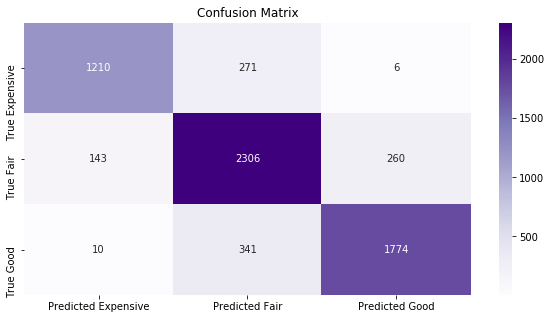

In [61]:
# Setting up our confusion matrix 
svm_confusion_matrix = confusion_matrix(y_test,y_pred_svm)

# Putting the confusion matrix in a DataFrame
svm_confusion_matrix = pd.DataFrame(data = svm_confusion_matrix,\
                                   columns = ['Predicted Expensive', 'Predicted Fair', 'Predicted Good'],\
                                  index = ['True Expensive','True Fair', 'True Good'])

# Setting up our classification_report
svm_classification_report = classification_report(y_test,y_pred_svm)
svm_scores_dict = classification_report(y_test,y_pred_svm, output_dict = True)

# Printing classification report
print(f'Classification Report \n {svm_classification_report}')

# Visualizing the heatmap
plt.figure(figsize = (10,5))
sns.heatmap(svm_confusion_matrix, annot = True, cmap='Purples', fmt = 'g')
plt.title('Confusion Matrix')
plt.show()

---
##### AdaBoost Classifier
---

In [62]:
# Intiate a parameter grid for AdaBoost Classifier

ada_param_grid = [
    
    {'scaler': [None],
    'dim_reducer': [PCA()],
    'dim_reducer__n_components': [None],
    'model': [AdaBoostClassifier(random_state = 8)],
    'model__n_estimators': [200,400,600],
    'model__learning_rate': [0.5,1,1.5]}
]

##### Note:
- No PCA dimension reduction applied by setting `n_components` = `None` asit significantly reduces the prerformance of the model.

- Scaler is set to None as AdaBoost algorithms are immune to scaling. Therefore to save on computational power we will not scale the training data.

In [63]:
# Instantiate the logistic regression grid search

ada_gs = GridSearchCV(model_pipeline, param_grid=ada_param_grid, cv=5, verbose=1, scoring = 'accuracy')

In [64]:
%%time


#Fitting the logistic Reg GS
fitted_ada_gs = ada_gs.fit(X_rem, y_rem)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 158.9min finished


Wall time: 2h 44min 11s


---

In [65]:
#Check for best parameters and best score 

print("Best Parameters: ", fitted_ada_gs.best_params_)
print("Best Score: ", fitted_ada_gs.best_score_)

Best Parameters:  {'dim_reducer': PCA(), 'dim_reducer__n_components': None, 'model': AdaBoostClassifier(learning_rate=1, n_estimators=400, random_state=8), 'model__learning_rate': 1, 'model__n_estimators': 400, 'scaler': None}
Best Score:  0.917851770659005


In [66]:
#Use best model to predict test set values

y_pred_ada = fitted_ada_gs.predict(X_test)

In [67]:
#Compare Training and Test set scores to ensure we are not over or under-fitting

print('Training Score: ', fitted_ada_gs.score(X_rem,y_rem))
print('Test Score: ', fitted_ada_gs.score(X_test,y_test))

Training Score:  0.9261241311435074
Test Score:  0.8990666033855402


Classification Report 
               precision    recall  f1-score   support

   Expensive       0.95      0.92      0.93      1487
        Fair       0.88      0.88      0.88      2709
        Good       0.89      0.91      0.90      2125

    accuracy                           0.90      6321
   macro avg       0.91      0.90      0.90      6321
weighted avg       0.90      0.90      0.90      6321



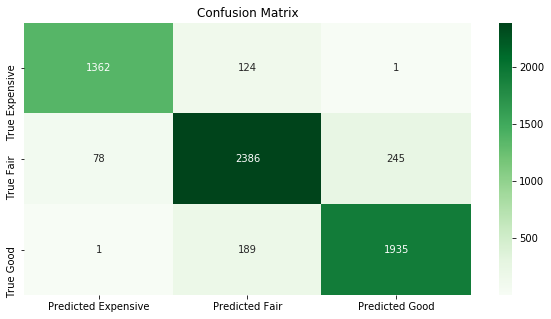

In [68]:
# Setting up our confusion matrix 
ada_confusion_matrix = confusion_matrix(y_test,y_pred_ada)

# Putting the confusion matrix in a DataFrame
ada_confusion_matrix = pd.DataFrame(data = ada_confusion_matrix,\
                                   columns = ['Predicted Expensive', 'Predicted Fair', 'Predicted Good'],\
                                  index = ['True Expensive','True Fair', 'True Good'])

# Setting up our classification_report
ada_classification_report = classification_report(y_test,y_pred_ada)
ada_scores_dict = classification_report(y_test,y_pred_ada, output_dict = True)

# Printing classification report
print(f'Classification Report \n {ada_classification_report}')

# Visualizing the heatmap
plt.figure(figsize = (10,5))
sns.heatmap(ada_confusion_matrix, annot = True, cmap='Greens', fmt = 'g')
plt.title('Confusion Matrix')
plt.show()

----

---

### Summary

In [69]:
#intialize a dataframe to store all results
model_names = ['Logistic Regression', 'Decision Trees', 'Random Forest', 'KNNs', 'SVC', 'AdaBoost']
results = pd.DataFrame(columns = ['Accuracy', 'Recall', 'Precision', 'F1_score'], index = model_names)

In [70]:
#Write a loop to summarize all results by using confusion matrix dictionaries
reports = [logreg_scores_dict, dt_scores_dict, rf_scores_dict, knn_scores_dict, svm_scores_dict, ada_scores_dict]

for row in range(0,results.shape[0]):
    results.Accuracy[row] = round(reports[row]['accuracy'],3)
    results.Recall[row] = round(reports[row]['macro avg']['recall'],3)
    results.Precision[row] = round(reports[row]['macro avg']['precision'],3)
    results.F1_score[row] = round(reports[row]['macro avg']['f1-score'],3)

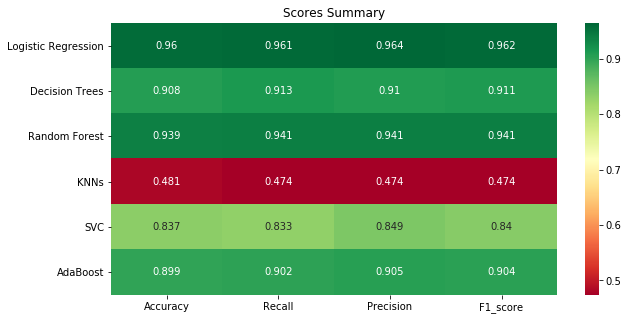

In [71]:
#display the results
results = results.astype('float')
plt.figure(figsize = (10,5))
sns.heatmap(results, annot = True, cmap='RdYlGn', fmt = 'g')
plt.title('Scores Summary')
plt.show()



---

The text only results show `LogisticRegression` performed the best in all key metrics with `KNNs` performing the worst with merely a 47% accuracy. All other models also had a 90+% in all metrics except `Support Vector Classifier` which lagged behind around 85% for all metrics. We will continue to evaluate and see if the text data will give any support to our model and provide any further improvements in our predictions. 

#### Saving top 3 models with best results

In [73]:
# importing joblib to save models 
from joblib import dump, load

In [74]:
dump(fitted_logreg_gs, 'all_feat_models/all_feat_logreg.joblib') 
dump(fitted_rf_gs, 'all_feat_models/all_feat_rf.joblib') 
dump(fitted_ada_gs, 'all_feat_models/all_feat_adaboost.joblib') 

['all_feat_models/all_feat_adaboost.joblib']

### Fin.